In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, reduce
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import modified_mnist_dataloader_test, modified_mnist_dataloader_train, mnist_dataloader_train
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 
from experiment import OptiEBM

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def make_adaptive_experiment(config):
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    adapt = OptiEBM(config, ebm)
    return adapt

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def pixelwise_varaince(imgs):
    ex = reduce(imgs, "b h w -> h w", "mean")
    ex2 = reduce(imgs**2, "b h w -> h w", "mean")
    return ex2 - ex**2

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [2]:
model_name = "modified_mnist/vae/langvein/inpainting"
config = get_model_config(model_name)

In [3]:
config["exp_params"]["batch_size"] = 1
dm = modified_mnist_dataloader_test(config, path=path)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [5]:
config["operator_params"]["size"] = 32

In [6]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def random_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.random_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return out

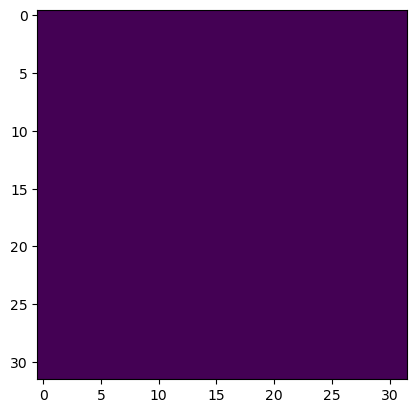

100%|██████████| 10/10 [00:00<00:00, 11.75it/s]
/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


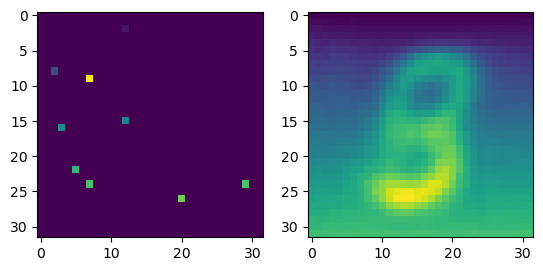

100%|██████████| 10/10 [00:00<00:00, 27.88it/s]


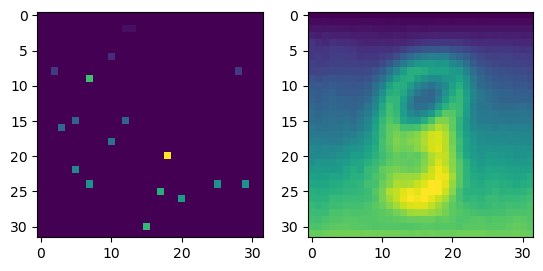

100%|██████████| 10/10 [00:00<00:00, 28.17it/s]


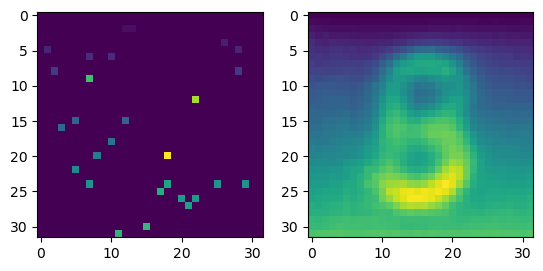

100%|██████████| 10/10 [00:00<00:00, 28.27it/s]


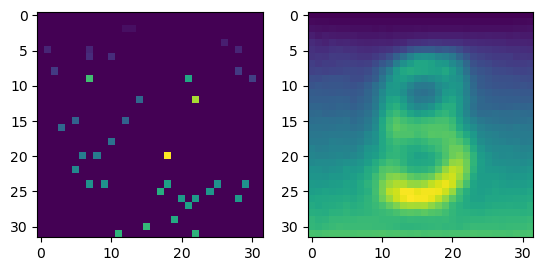

100%|██████████| 10/10 [00:00<00:00, 28.09it/s]


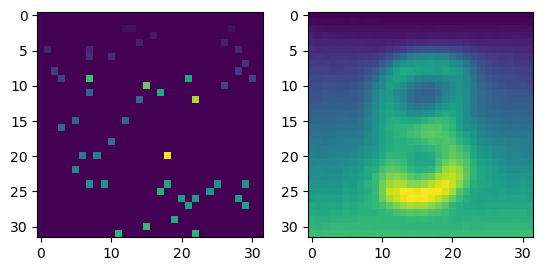

100%|██████████| 10/10 [00:00<00:00, 27.71it/s]


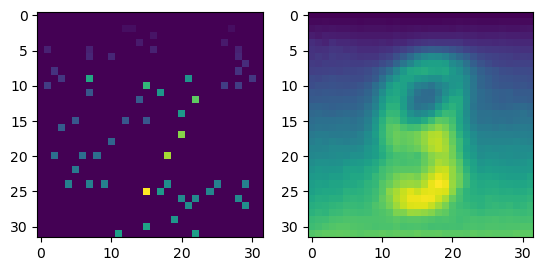

100%|██████████| 10/10 [00:00<00:00, 28.10it/s]


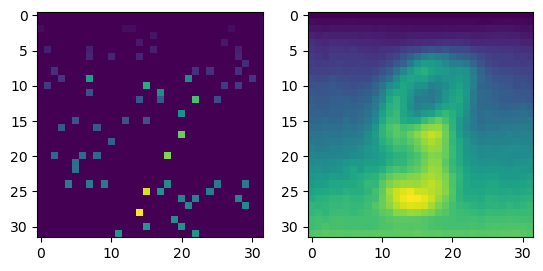

100%|██████████| 10/10 [00:00<00:00, 28.30it/s]


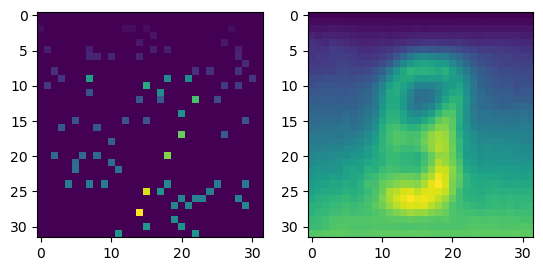

100%|██████████| 10/10 [00:00<00:00, 28.40it/s]


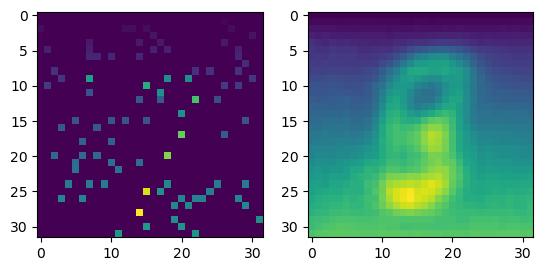

100%|██████████| 10/10 [00:00<00:00, 28.15it/s]


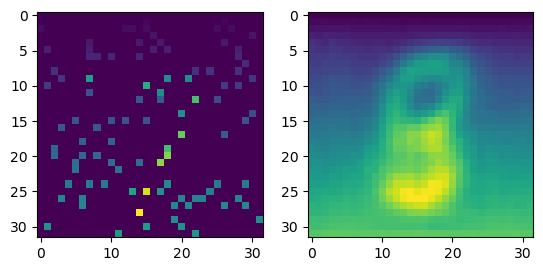

100%|██████████| 10/10 [00:00<00:00, 27.99it/s]


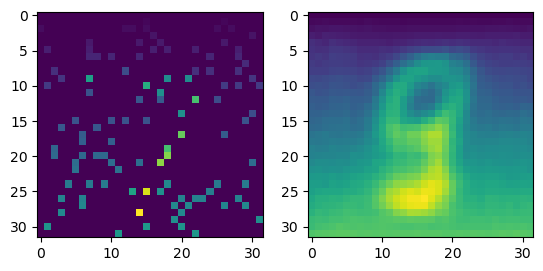

100%|██████████| 10/10 [00:00<00:00, 27.61it/s]


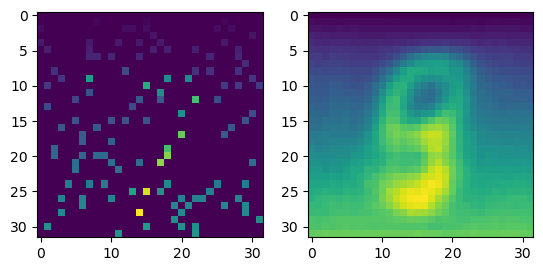

100%|██████████| 10/10 [00:00<00:00, 27.66it/s]


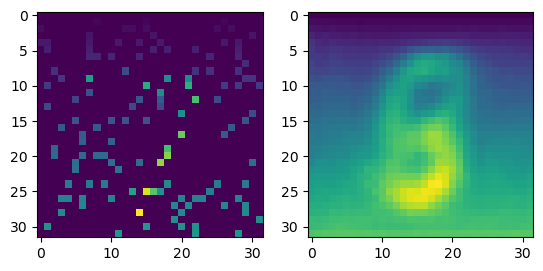

100%|██████████| 10/10 [00:00<00:00, 27.38it/s]


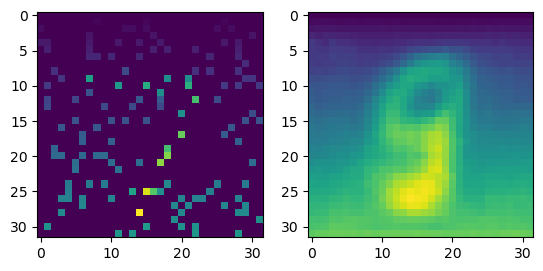

100%|██████████| 10/10 [00:00<00:00, 28.08it/s]


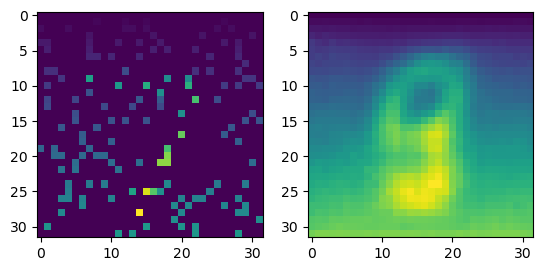

100%|██████████| 10/10 [00:00<00:00, 28.17it/s]


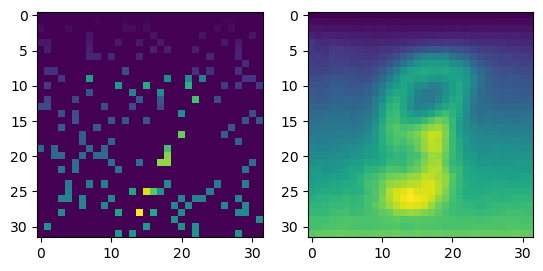

100%|██████████| 10/10 [00:00<00:00, 27.62it/s]


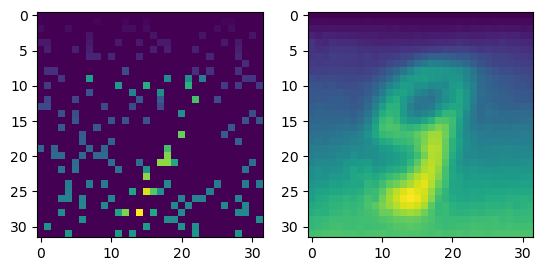

100%|██████████| 10/10 [00:00<00:00, 27.81it/s]


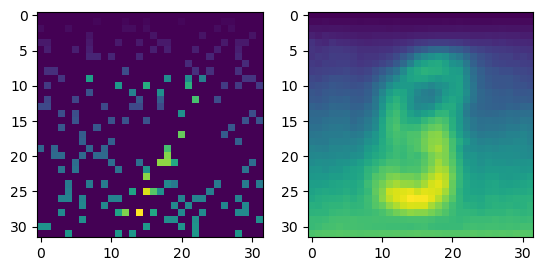

100%|██████████| 10/10 [00:00<00:00, 27.88it/s]


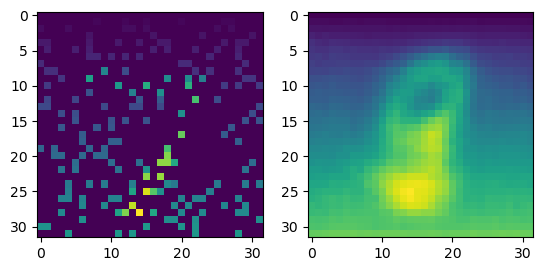

100%|██████████| 10/10 [00:00<00:00, 27.89it/s]


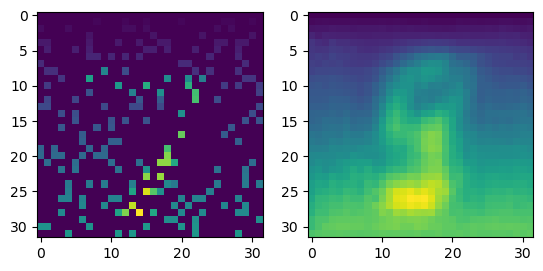

In [7]:
out1 = random_iteration(x)

In [8]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def thomospon_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.thomospon_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return out

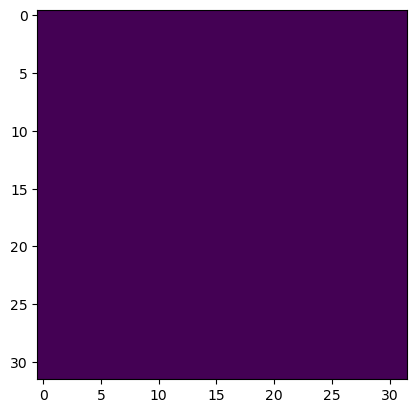

100%|██████████| 10/10 [00:00<00:00, 27.89it/s]


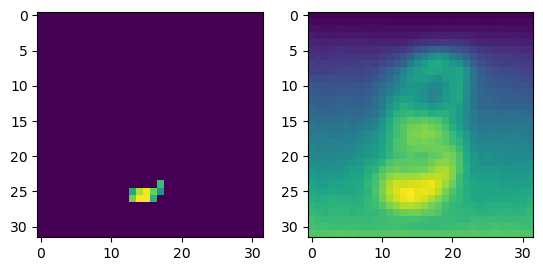

100%|██████████| 10/10 [00:00<00:00, 27.57it/s]


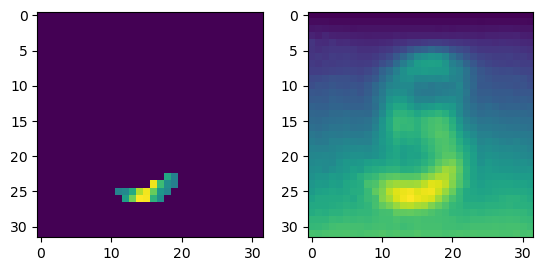

100%|██████████| 10/10 [00:00<00:00, 27.66it/s]


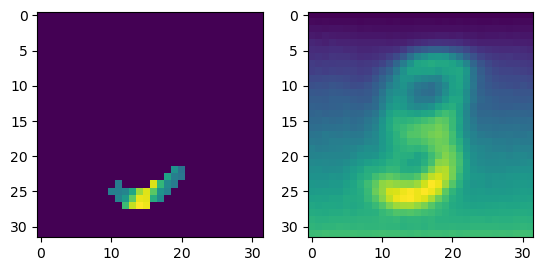

100%|██████████| 10/10 [00:00<00:00, 27.81it/s]


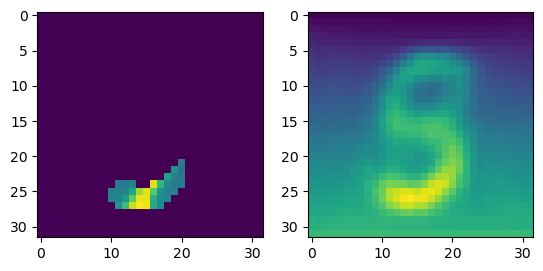

100%|██████████| 10/10 [00:00<00:00, 27.35it/s]


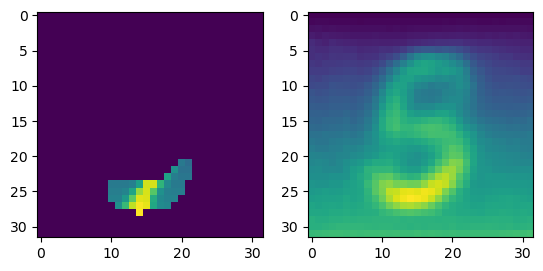

100%|██████████| 10/10 [00:00<00:00, 27.54it/s]


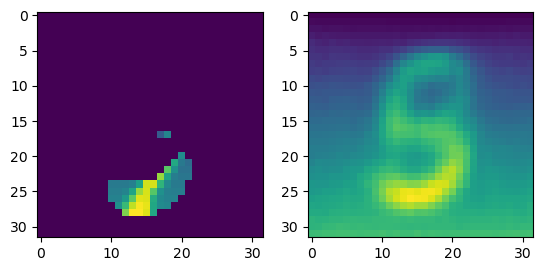

100%|██████████| 10/10 [00:00<00:00, 28.04it/s]


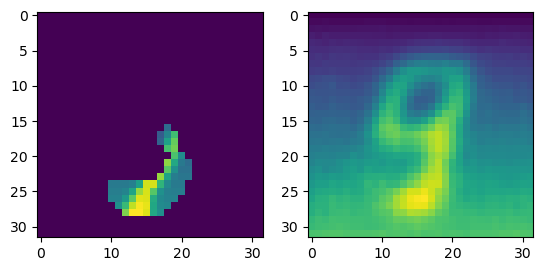

100%|██████████| 10/10 [00:00<00:00, 28.11it/s]


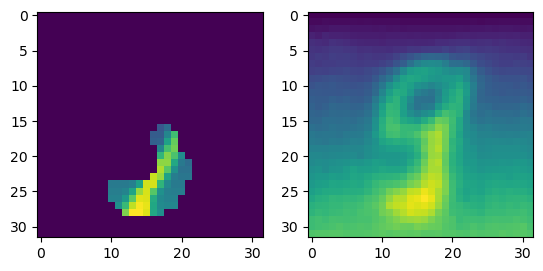

100%|██████████| 10/10 [00:00<00:00, 28.13it/s]


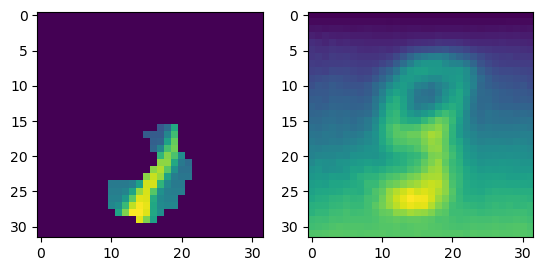

100%|██████████| 10/10 [00:00<00:00, 27.42it/s]


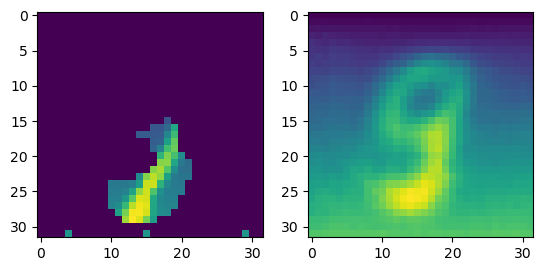

100%|██████████| 10/10 [00:00<00:00, 27.81it/s]


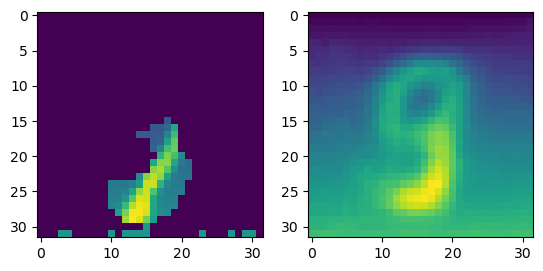

100%|██████████| 10/10 [00:00<00:00, 27.39it/s]


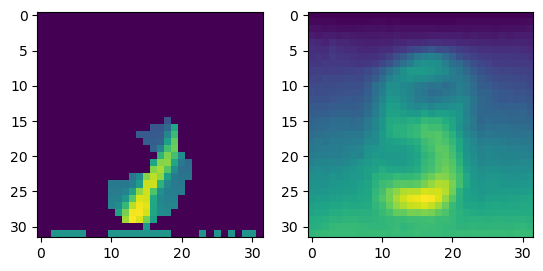

100%|██████████| 10/10 [00:00<00:00, 27.92it/s]


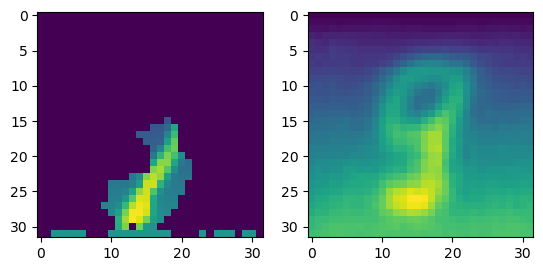

100%|██████████| 10/10 [00:00<00:00, 27.91it/s]


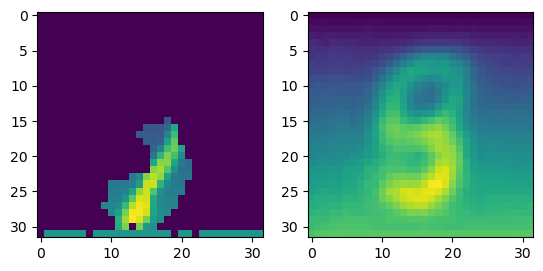

100%|██████████| 10/10 [00:00<00:00, 27.89it/s]


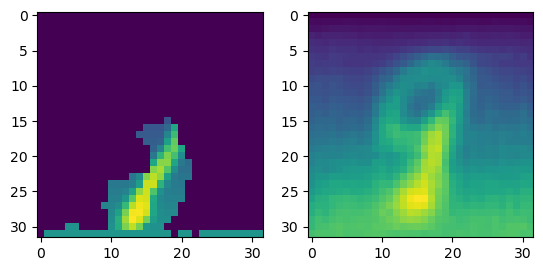

100%|██████████| 10/10 [00:00<00:00, 28.07it/s]


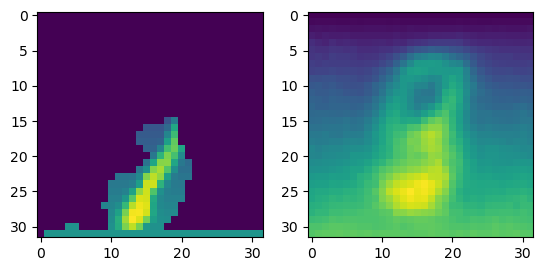

100%|██████████| 10/10 [00:00<00:00, 28.19it/s]


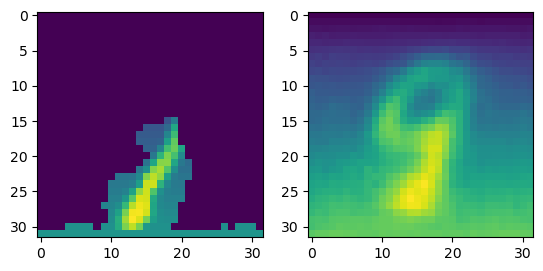

100%|██████████| 10/10 [00:00<00:00, 27.87it/s]


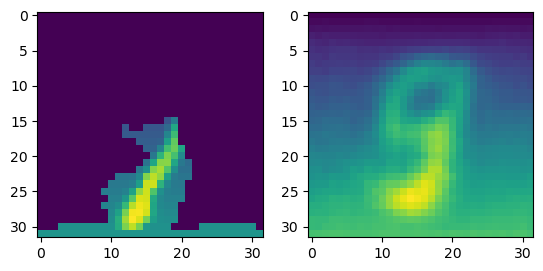

100%|██████████| 10/10 [00:00<00:00, 27.91it/s]


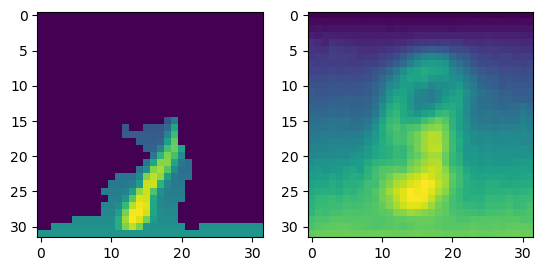

100%|██████████| 10/10 [00:00<00:00, 27.96it/s]


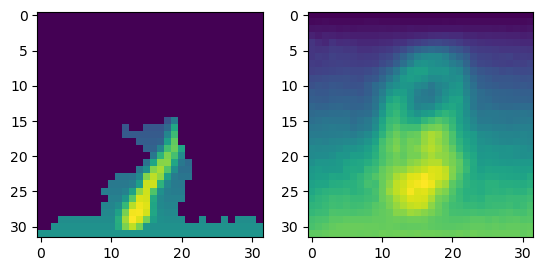

In [9]:
out2 = thomospon_iteration(x)

In [10]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def ucb_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    out= []
    n_samples = 10
    max_ = 0
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.ucb_sample(imgs, k=50, num_pixels_per_samples=10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return out

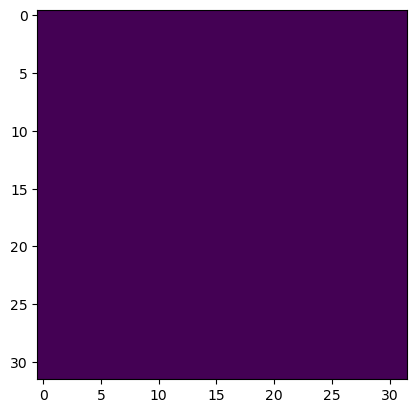

100%|██████████| 10/10 [00:00<00:00, 32.70it/s]


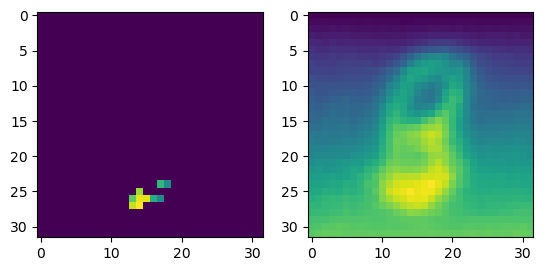

100%|██████████| 10/10 [00:00<00:00, 31.21it/s]


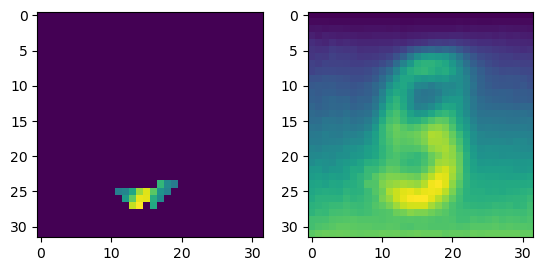

100%|██████████| 10/10 [00:00<00:00, 28.06it/s]


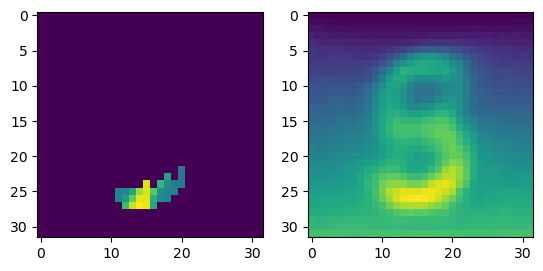

100%|██████████| 10/10 [00:00<00:00, 28.26it/s]


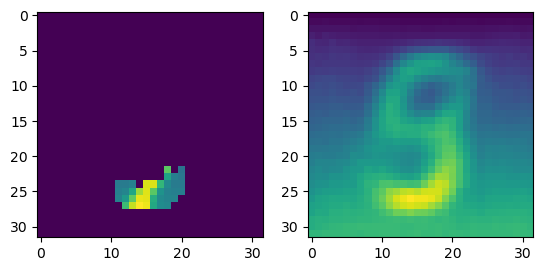

100%|██████████| 10/10 [00:00<00:00, 28.35it/s]


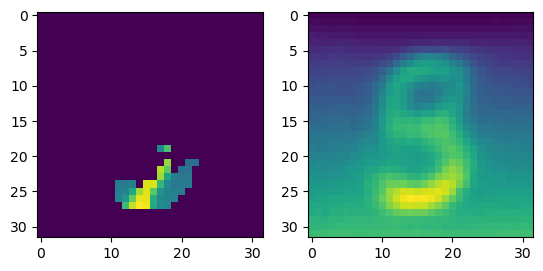

100%|██████████| 10/10 [00:00<00:00, 28.21it/s]


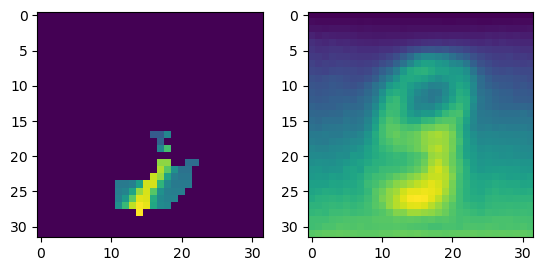

100%|██████████| 10/10 [00:00<00:00, 28.23it/s]


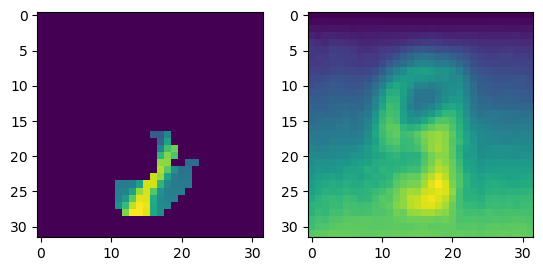

100%|██████████| 10/10 [00:00<00:00, 28.12it/s]


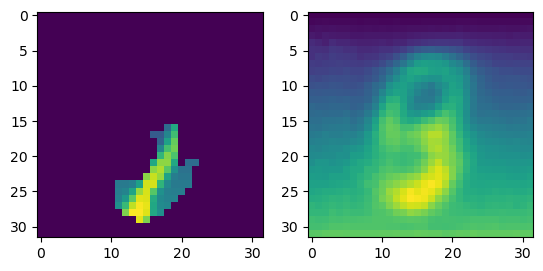

100%|██████████| 10/10 [00:00<00:00, 28.23it/s]


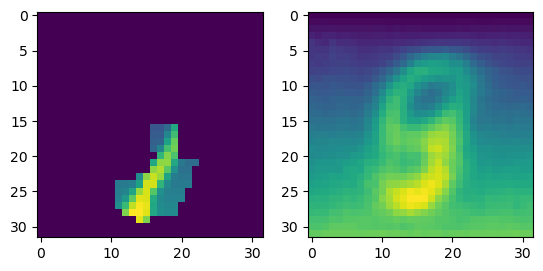

100%|██████████| 10/10 [00:00<00:00, 28.03it/s]


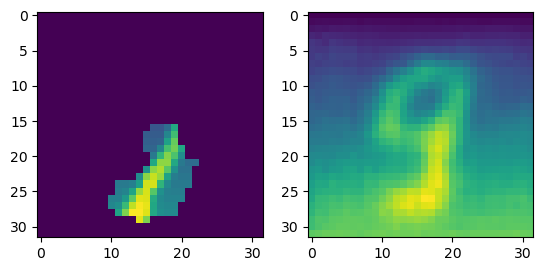

100%|██████████| 10/10 [00:00<00:00, 27.62it/s]


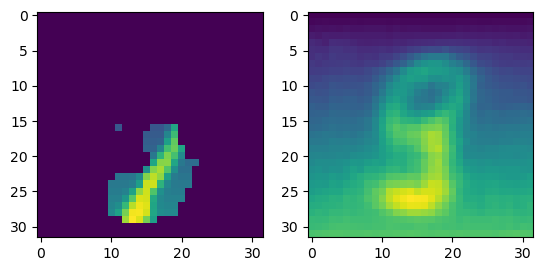

100%|██████████| 10/10 [00:00<00:00, 27.78it/s]


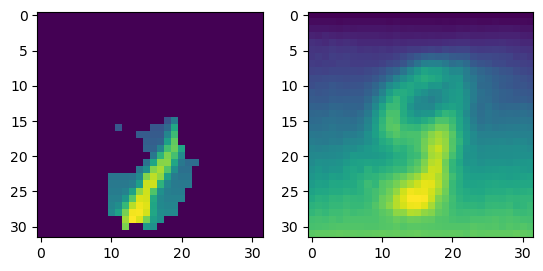

100%|██████████| 10/10 [00:00<00:00, 28.09it/s]


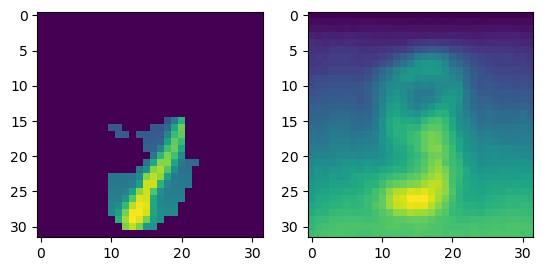

100%|██████████| 10/10 [00:00<00:00, 28.41it/s]


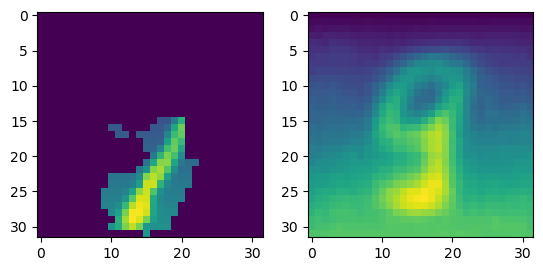

100%|██████████| 10/10 [00:00<00:00, 27.91it/s]


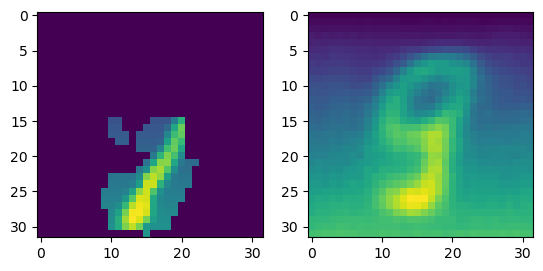

100%|██████████| 10/10 [00:00<00:00, 27.71it/s]


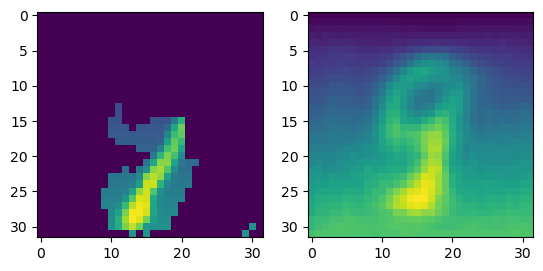

100%|██████████| 10/10 [00:00<00:00, 28.05it/s]


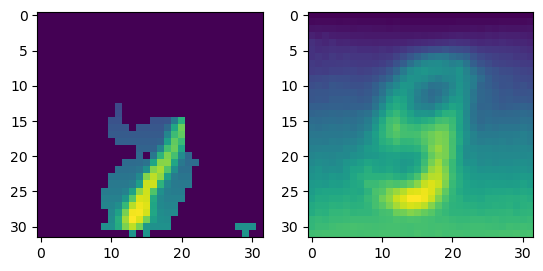

100%|██████████| 10/10 [00:00<00:00, 27.90it/s]


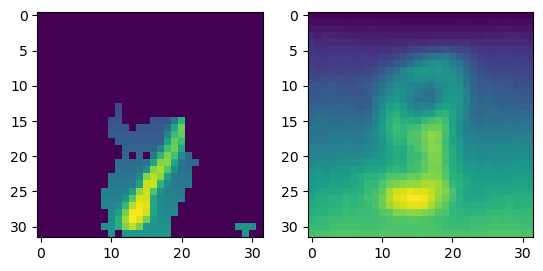

100%|██████████| 10/10 [00:00<00:00, 28.13it/s]


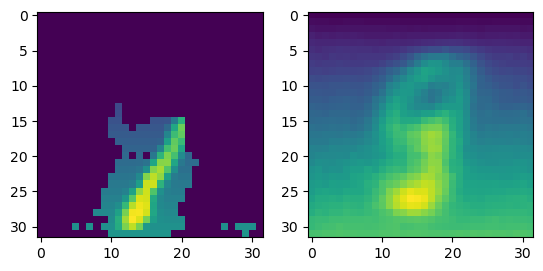

100%|██████████| 10/10 [00:00<00:00, 28.48it/s]


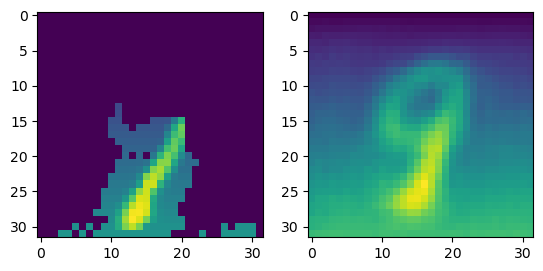

In [11]:
out3= ucb_iteration(x)

In [12]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def random_pick_iteration(img):
    dm = modified_mnist_dataloader_train(config, path=path, shuffle=True)
    config["exp_params"]["batch_size"] = 1
    gen = iter(dm)
    x, y = next(gen)
    x = x.to("cuda")
    adapt = make_adaptive_experiment(config)
    ri, A = adapt.random_pick_sample(x, 10)
    adapt.update_operator(A)
    x_tilde = adapt.ebm.operator(img)
    return torch.max(x_tilde).cpu().detach().numpy()
    

out1 = random_pick_iteration(x)

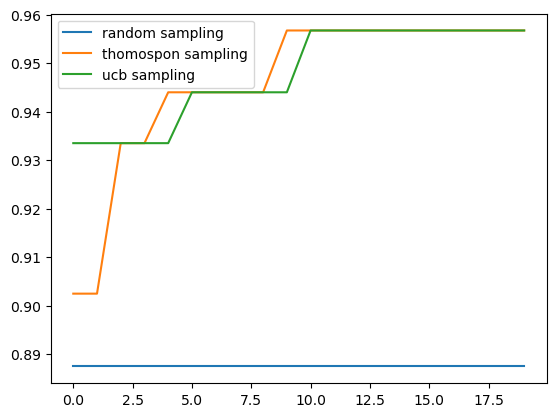

In [14]:
plt.plot([out1]*len(out3))
plt.plot(out2)
plt.plot(out3)
plt.legend(['random sampling','thomospon sampling', 'ucb sampling'])
plt.show()

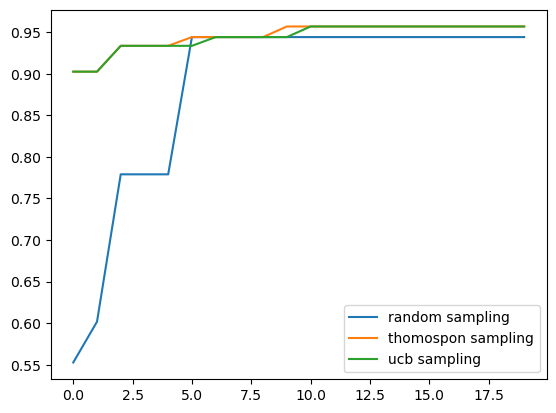

In [12]:
plt.plot(out1)
plt.plot(out2)
plt.plot(out3)
plt.legend(['random sampling','thomospon sampling', 'ucb sampling'])
plt.show()

In [13]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def ucb_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    out= []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in range(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.ucb_sample(imgs, k=50, num_pixels_per_samples=10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach().numpy())
    return out

In [14]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def thomospon_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.thomospon_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach().numpy())
    return out

In [15]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def random_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.random_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach().numpy())
    return out

In [32]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def random_pick_iteration(img):
    dm = modified_mnist_dataloader_train(config, path=path, shuffle=True)
    config["exp_params"]["batch_size"] = 1
    gen = iter(dm)
    x, y = next(gen)
    x = x.to("cuda")
    adapt = make_adaptive_experiment(config)
    ri, A = adapt.random_pick_sample(x, 10)
    adapt.update_operator(A)
    x_tilde = adapt.ebm.operator(img)
    return torch.max(x_tilde).cpu().detach().numpy()
    

In [33]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [34]:
random_pick_iteration(x)

array(0.9315623, dtype=float32)

100%|██████████| 10/10 [00:00<00:00, 29.23it/s]


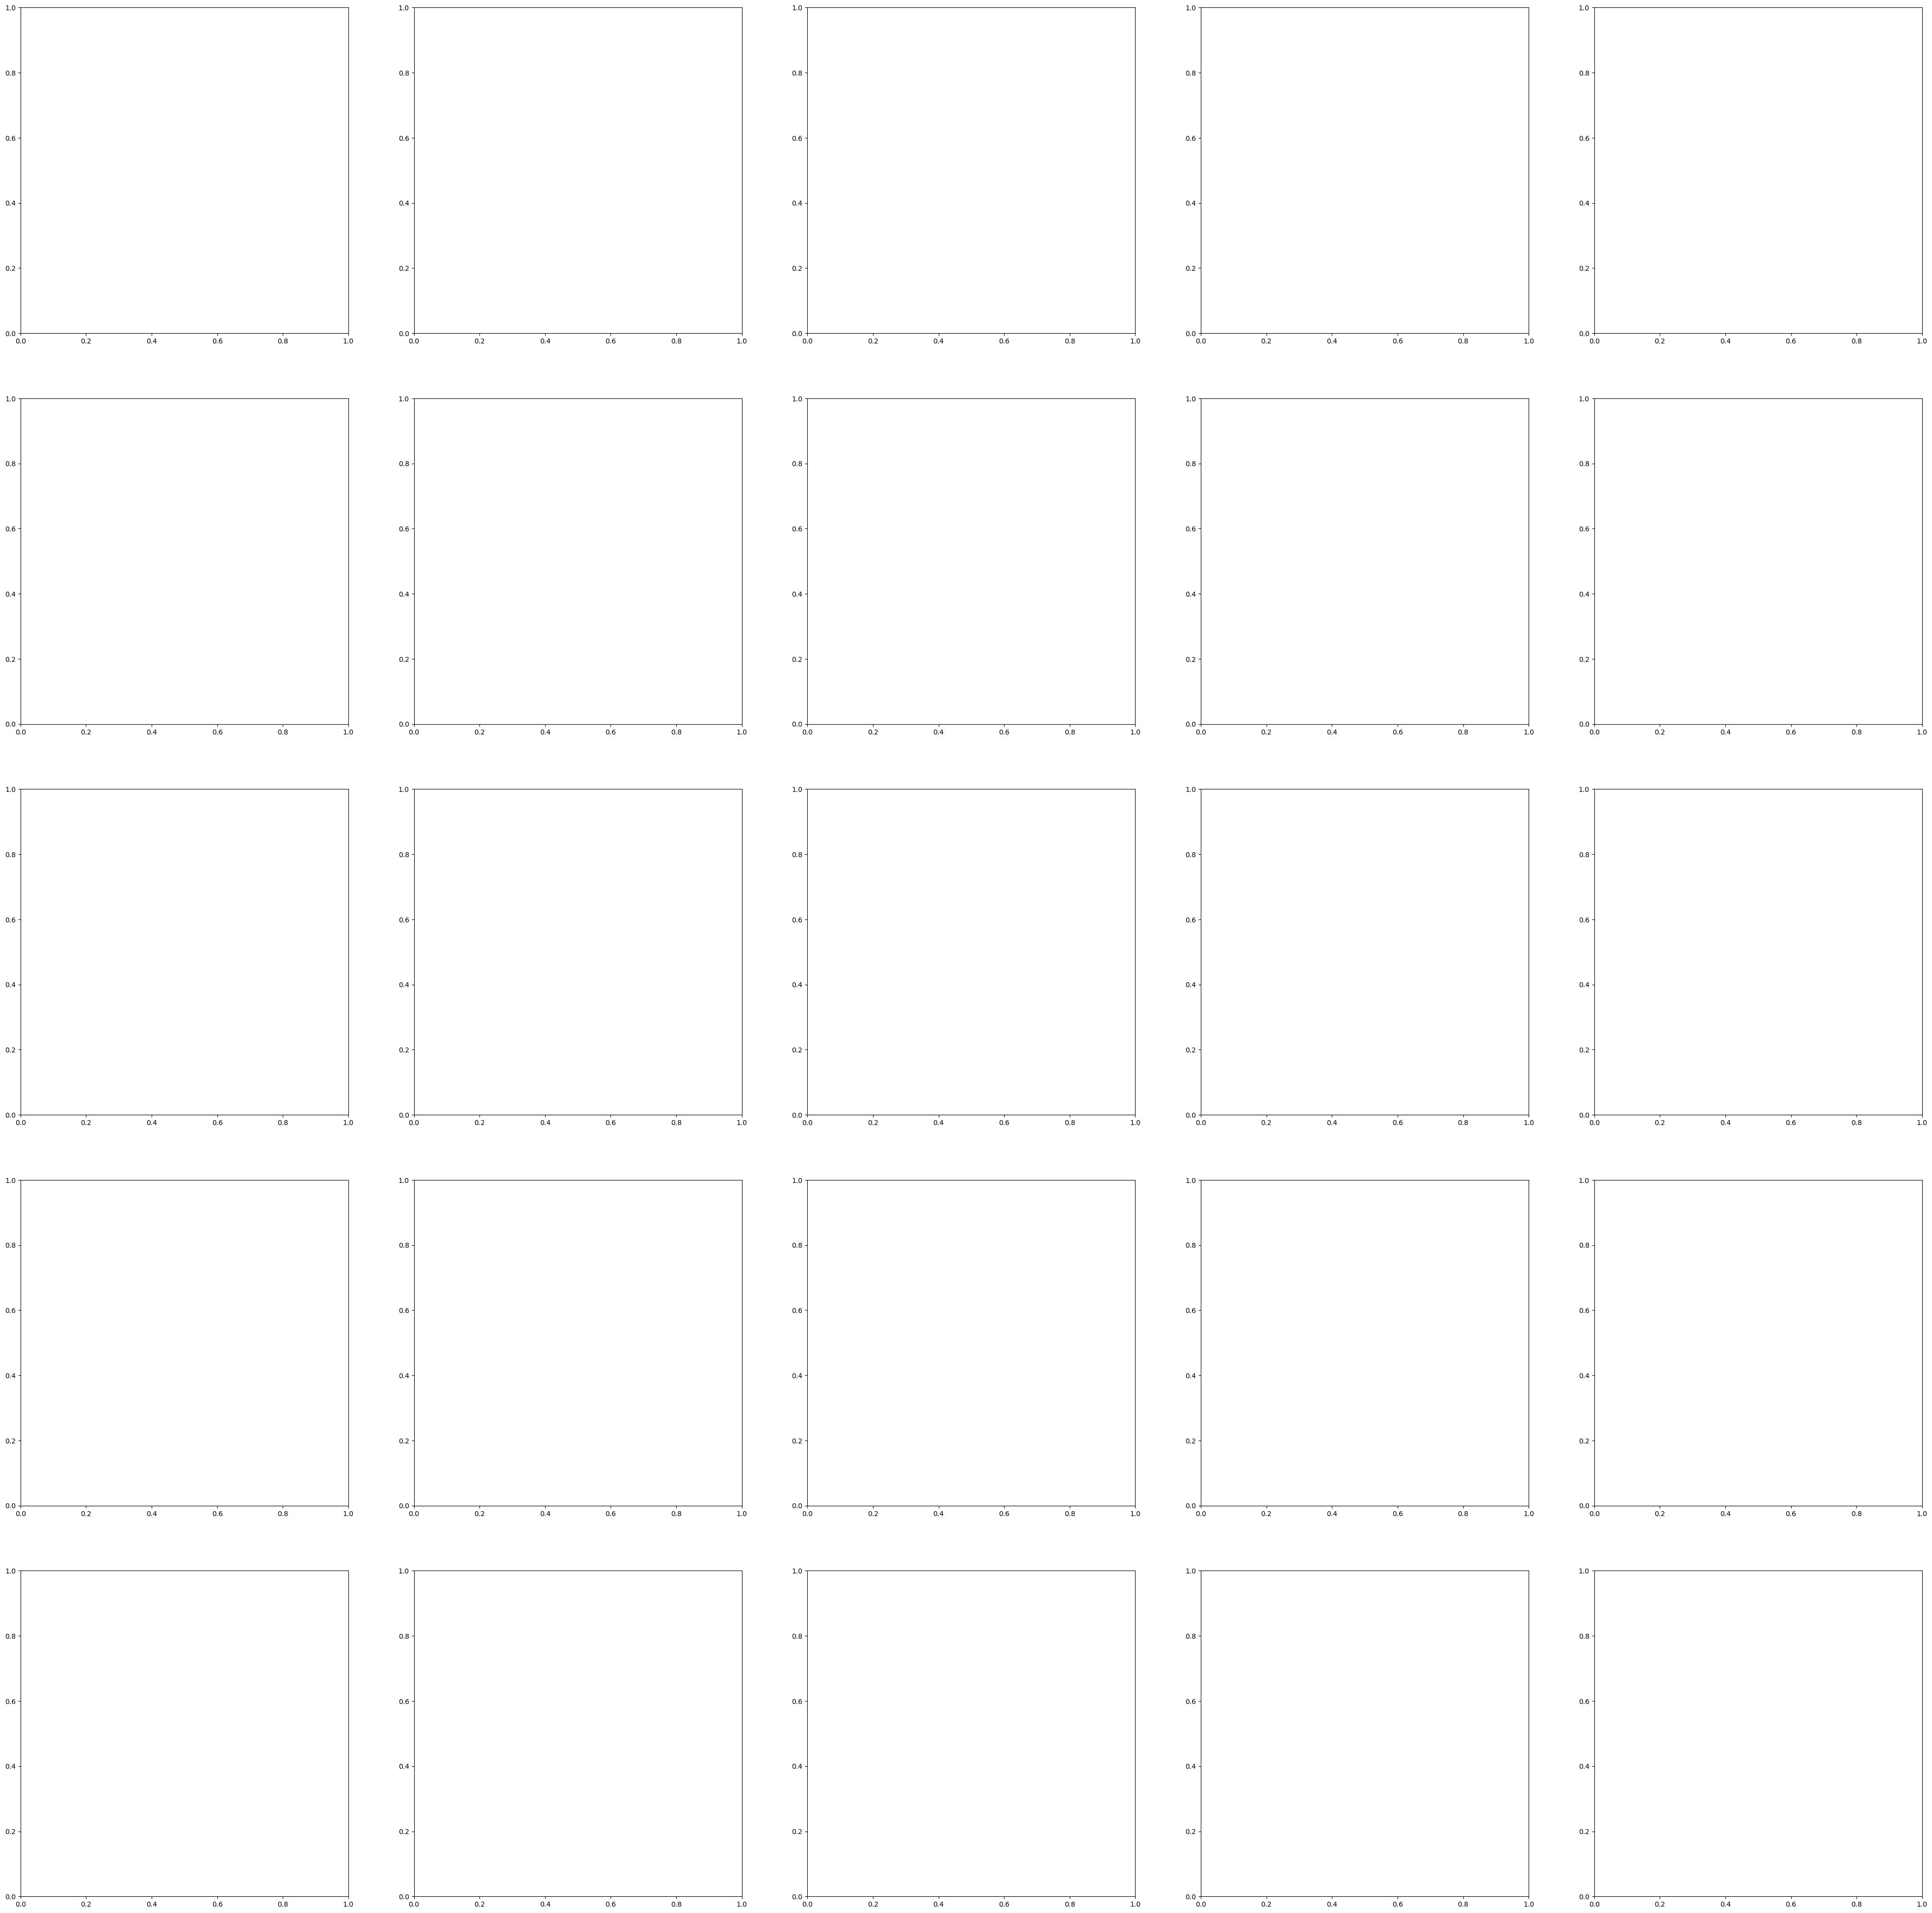

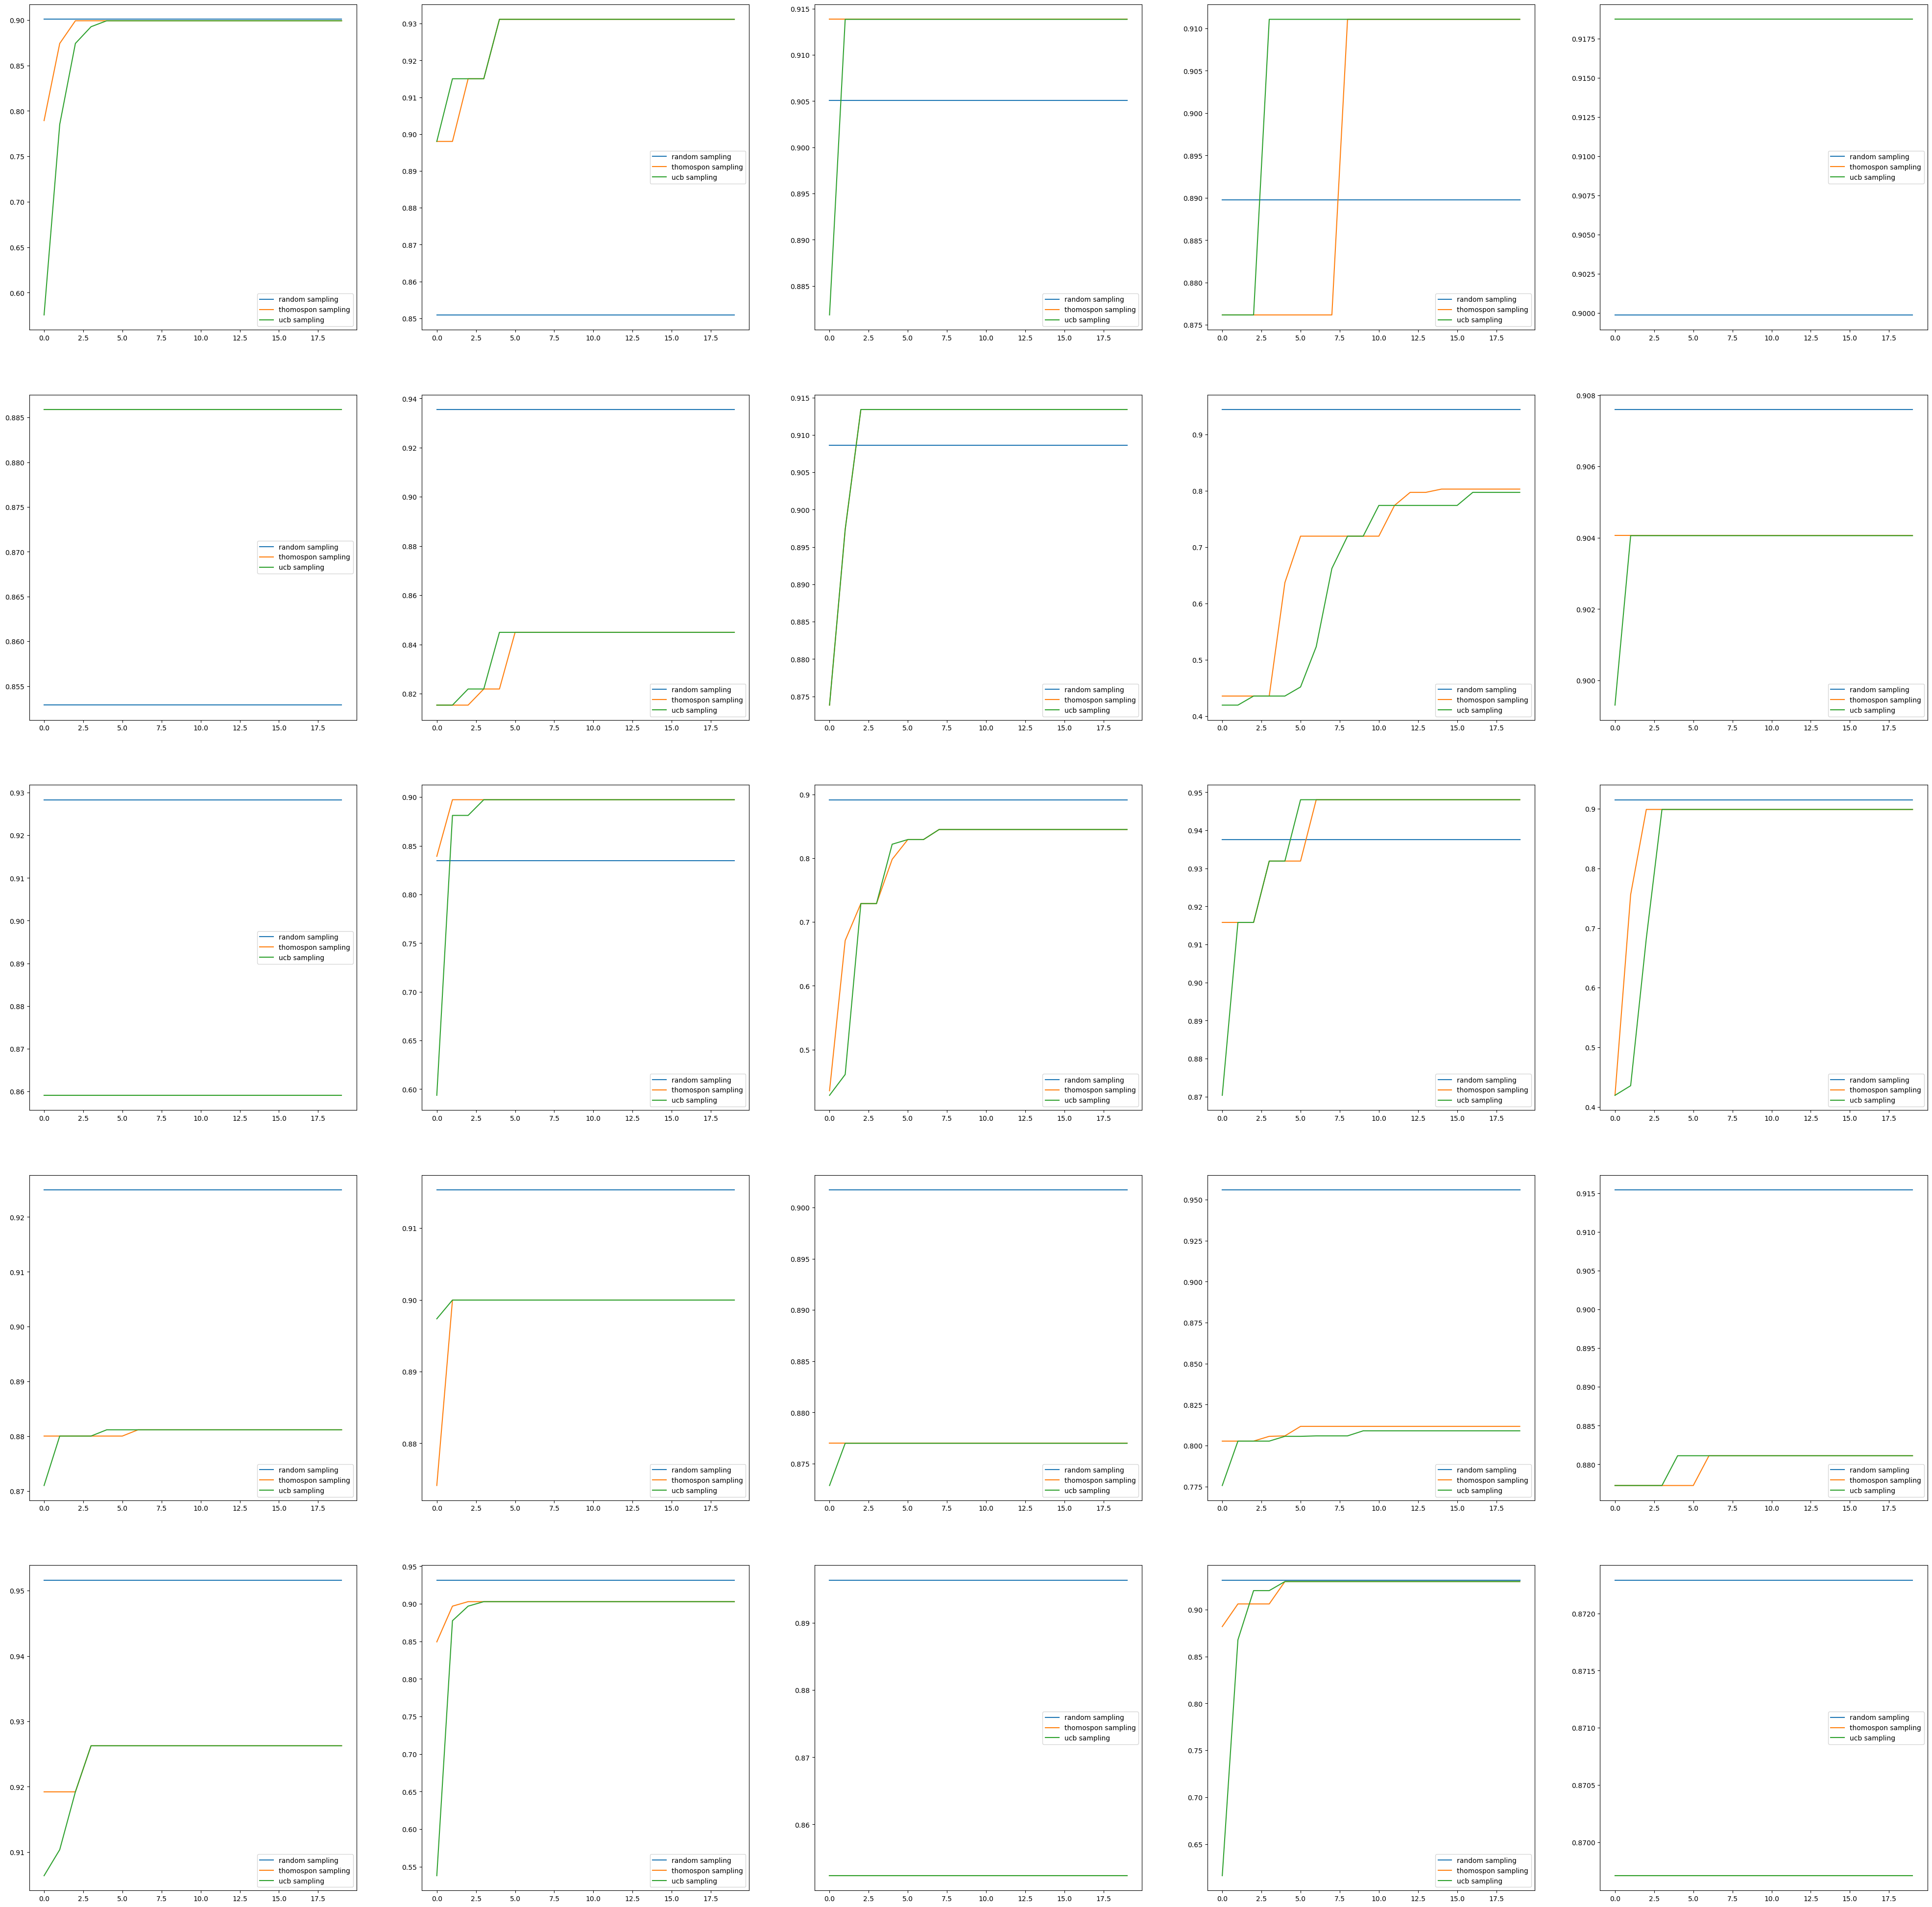

In [39]:
fig, axs = plt.subplots(5, 5, figsize=(50, 50))
for l in range(5):
    for t in range(5):
        x, y = next(gen)
        x = x.to("cuda")
        ucb=  ucb_iteration(x)
        thomospon = thomospon_iteration(x)
        random = random_pick_iteration(x)
        axs[l, t].plot([random]*len(ucb))
        axs[l, t].plot(ucb)
        axs[l, t].plot(thomospon)
        axs[l, t].legend(['random sampling','thomospon sampling', 'ucb sampling'])
plt.show()